# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [123]:
import nibabel as nib
import numpy as np
import pandas as pd
import math
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import masking as nimask
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import math 
import os
from scripts.eda_func import *

# Define what data to use

In [141]:
#Define what data to use
data_folder = 'ADHD200_7'

#If a mac
mac = True
path_addon = '.nosync' if mac == True else ''

#Regions
num_of_regions = 7
regions = [f"ROI_{i+1}" for i in range(num_of_regions)]

# Read in the data

In [142]:
#Just run ones
#mean, var = get_mean_and_var_stats(data_folder = 'ADHD200_7', 
#                                   mac = True)

#Load mean and variance
mean_pr_roi = pd.read_csv(f'data{path_addon}/stats/{data_folder}_mean_subject.csv', 
                          sep = ';',
                          index_col = 'Unnamed: 0')
var_pr_roi = pd.read_csv(f'data{path_addon}/stats/{data_folder}_variance_subject.csv', 
                         sep = ';',
                         index_col = 'Unnamed: 0')

#Expand subject ID
mean_pr_roi['Subject_ID'] = mean_pr_roi['Subject_ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))
#Expand subject ID
var_pr_roi['Subject_ID'] = var_pr_roi['Subject_ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))

print('Mean Shape:', mean_pr_roi.shape)
print('Variance Shape:', var_pr_roi.shape)
print('Unique Subjects:', len(mean_pr_roi['Subject_ID'].unique()))

Mean Shape: (394, 10)
Variance Shape: (394, 10)
Unique Subjects: 216


### Add extra meta data

In [143]:
meta_data = pd.read_csv('data.nosync/phenotypic/ADHD200_phenotypic.csv')
#Expand subject ID
meta_data['ScanDir ID'] = meta_data['ScanDir ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))
#Select columns
meta_data = meta_data[['ScanDir ID', 'Gender', 'DX']]
#Replace values
meta_data['DX'] = meta_data['DX'].replace({0: 'TD', 1: 'ADHD-Combined', 2: 'ADHD-Hyperactive/Impulsive', 3: 'ADHD-Inattentive'})
meta_data['Gender'] = meta_data['Gender'].replace({0: 'Female', 1: 'Male'})

meta_data = meta_data.drop_duplicates('ScanDir ID')

#Merge with scans
mean_pr_roi = pd.merge(left = mean_pr_roi, 
                        right = meta_data,
                        left_on= 'Subject_ID',
                        right_on= 'ScanDir ID')

var_pr_roi = pd.merge(left = var_pr_roi, 
                        right = meta_data,
                        left_on= 'Subject_ID',
                        right_on= 'ScanDir ID')

# EDA

## Describe the data

### Gender & Diagnosis

In [144]:
print('Scanes from males:', mean_pr_roi['Gender'].value_counts()[0])
print('Scanes from females:', mean_pr_roi['Gender'].value_counts()[1])
print('=' * 30)
print('Number of TD scans:', mean_pr_roi['DX'].value_counts()[0])
print('Number of ADHD-Combined scans:', mean_pr_roi['DX'].value_counts()[1])
print('Number of ADHD-Inattentive scans:', mean_pr_roi['DX'].value_counts()[2])
print('Number of ADHD-Hyperactive/Impulsive:', mean_pr_roi['DX'].value_counts()[3])

Scanes from males: 253
Scanes from females: 139
Number of TD scans: 183
Number of ADHD-Combined scans: 127
Number of ADHD-Inattentive scans: 82
Number of ADHD-Hyperactive/Impulsive: 2


In [145]:
mean_pr_roi[['Gender', 'DX']].value_counts()

Gender  DX                        
Male    ADHD-Combined                 105
Female  TD                             94
Male    TD                             89
        ADHD-Inattentive               57
Female  ADHD-Inattentive               25
        ADHD-Combined                  20
Male    ADHD-Hyperactive/Impulsive      2
Name: count, dtype: int64

### Numerical values

In [146]:
#Describe mean stats
mean_pr_roi[regions].describe()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,-0.003268,-0.003506,0.001417,0.009496,-0.011152,0.006347,-0.002818
std,0.112051,0.095822,0.114912,0.091526,0.166584,0.081300,0.117866
min,-0.430488,-0.453020,-0.428129,-0.436783,-2.048740,-0.500395,-1.462653
25%,-0.069005,-0.055255,-0.051119,-0.046039,-0.043342,-0.036599,-0.048002
50%,-0.008955,0.004100,0.006075,0.015951,-0.000025,0.008705,0.002896
75%,0.054045,0.055740,0.054071,0.070550,0.044179,0.056711,0.049183
max,0.629746,0.416660,1.221131,0.287427,0.476963,0.274843,0.417777


In [147]:
#Describe mean stats
var_pr_roi[regions].describe()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,0.369432,0.277053,0.284980,0.292929,0.346061,0.323434,0.370312
std,2.850500,1.689245,1.719906,1.685257,1.582899,1.357162,1.841081
min,0.060457,0.060006,0.055958,0.070056,0.059655,0.065601,0.087078
25%,0.132979,0.119850,0.126686,0.138310,0.119973,0.148589,0.165427
50%,0.179685,0.150321,0.158788,0.171876,0.158543,0.180293,0.207135
75%,0.251626,0.205197,0.203405,0.217631,0.236882,0.244319,0.263790
max,56.643735,33.571468,34.131812,33.502569,27.563038,25.537749,35.815922


#### Remove outliers

In [148]:
#Get subject ids with to high variance
subjects_to_remove = var_pr_roi[(var_pr_roi[regions] > 2).any(axis=1)]['Subject_ID'].to_list()
subjects_to_remove

['0010077', '1023964', '0010111', '0010014']

In [149]:
var_pr_roi

,Subject_ID,Session,Rest,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ScanDir ID,Gender,DX
0,3662296,1,1,0.142888,0.150762,0.170962,0.185499,0.120572,0.163543,0.196198,3662296,Female,TD
1,0010097,1,1,0.113084,0.096357,0.092602,0.112406,0.127484,0.120382,0.131933,0010097,Female,TD
2,0010064,1,1,0.115571,0.093272,0.142835,0.129178,0.117899,0.159768,0.162086,0010064,Male,ADHD-Combined
3,0010056,1,2,0.141436,0.117431,0.131250,0.121396,0.311922,0.131031,0.156478,0010056,Male,ADHD-Inattentive
4,4562206,1,1,0.172666,0.162733,0.196089,0.171016,0.132022,0.225070,0.209657,4562206,Female,TD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,3349205,1,1,0.140984,0.239341,0.179246,0.242462,0.286837,0.243227,0.311321,3349205,Female,ADHD-Inattentive
390,2054438,1,2,0.238455,0.282816,0.255975,0.337184,0.191245,0.287595,0.353493,2054438,Male,ADHD-Combined
391,0010107,1,1,0.081131,0.071144,0.085435,0.083739,0.067047,0.097005,0.109105,0010107,Male,ADHD-Inattentive
392,1127915,1,1,0.120470,0.106113,0.145853,0.127871,0.110404,0.129048,0.187911,1127915,Female,TD


In [150]:
var_pr_roi = var_pr_roi[~var_pr_roi['Subject_ID'].isin(subjects_to_remove)]
var_pr_roi.shape

(387, 13)

In [151]:
var_pr_roi[regions].describe()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,0.212629,0.182776,0.186650,0.197977,0.219049,0.226953,0.250801
std,0.137723,0.114898,0.117438,0.109281,0.181456,0.159453,0.173781
min,0.060457,0.060006,0.055958,0.070056,0.059655,0.065601,0.087078
25%,0.132634,0.119315,0.125843,0.137706,0.118950,0.148023,0.164866
50%,0.177489,0.149478,0.158139,0.171453,0.156879,0.179462,0.206239
75%,0.250443,0.202240,0.201735,0.215171,0.229120,0.240413,0.260515
max,1.483231,0.810907,1.109629,1.022029,1.428610,1.571490,1.463221


In [152]:
mean_pr_roi = mean_pr_roi[~mean_pr_roi['Subject_ID'].isin(subjects_to_remove)]
mean_pr_roi.shape

(387, 13)

## Distribution plots

### Variance

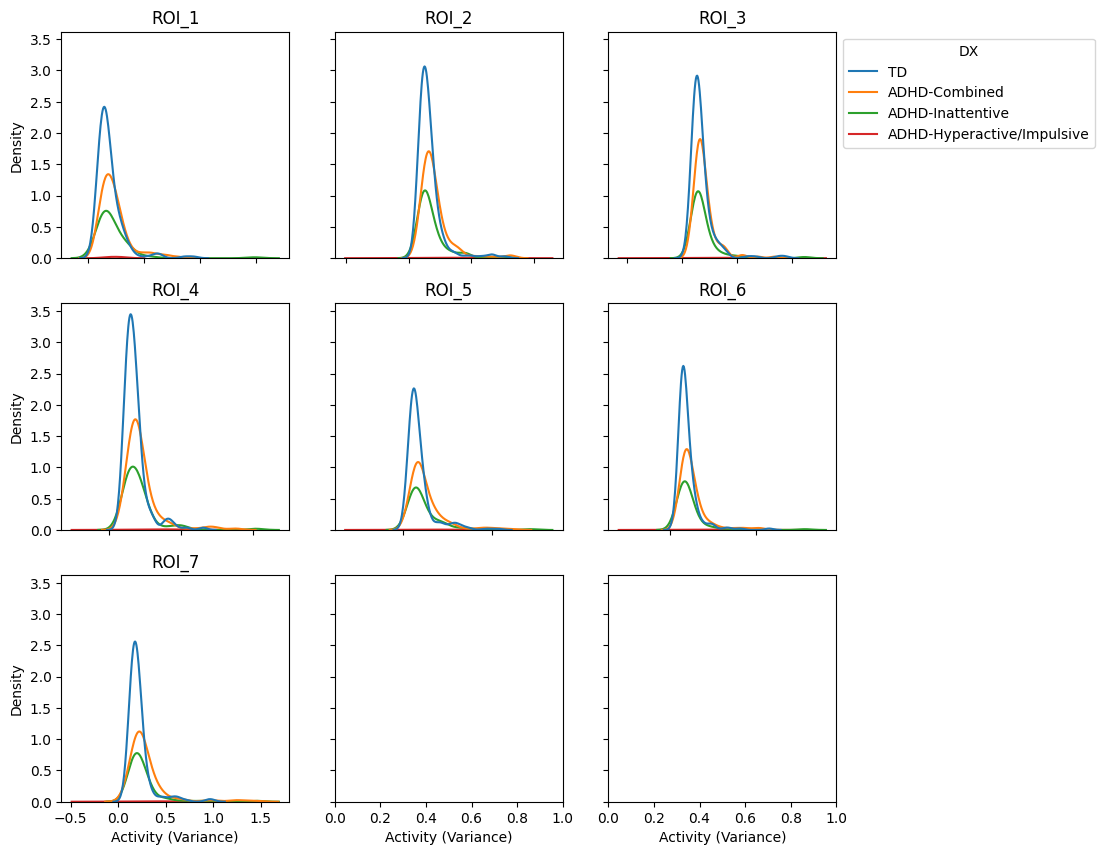

In [195]:
#Get axis limits
x_min = min(var_pr_roi[regions].min().to_list())-0.1
x_max = max(var_pr_roi[regions].max().to_list())+0.1

#Sub plot size
sub_size = math.ceil(math.sqrt(len(regions)))

fig, axs = plt.subplots(sub_size, sub_size, figsize=(10, 10))

temp_rois = regions.copy()

#Store y axis
y_max = []
y_min = []

for x in range(sub_size):
    for y in range(sub_size):
        if len(temp_rois) == 0:
            break
        if [x,y] == [0,sub_size-1]:
            sns.kdeplot(data = var_pr_roi, x = temp_rois[0], hue='DX', ax = axs[x, y], legend= True)
            axs[x, y].set_title(temp_rois[0])
            sns.move_legend(axs[x, y], "upper left", bbox_to_anchor=(1, 1))
        else:
            sns.kdeplot(data = var_pr_roi, x = temp_rois[0], hue='DX', ax = axs[x, y], legend= False)
            axs[x, y].set_title(temp_rois[0])

        #y_axis limits
        lim = axs[x,y].get_ylim()
        y_max.append(lim[1])
        y_min.append(lim[0])
        temp_rois.remove(temp_rois[0])

for ax in axs.flat:
    ax.set_ylim(min(y_min), max(y_max))
    ax.set(xlabel='Activity (Variance)', ylabel='Density')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
for ax in axs:
    print(ax)
    #ax.set_ylim(float(min(y_min)), max(y_max))

[<Axes: title={'center': 'ROI_1'}, xlabel='ROI_1', ylabel='Density'>
 <Axes: title={'center': 'ROI_2'}, xlabel='ROI_2', ylabel='Density'>
 <Axes: title={'center': 'ROI_3'}, xlabel='ROI_3', ylabel='Density'>]
[<Axes: title={'center': 'ROI_4'}, xlabel='ROI_4', ylabel='Density'>
 <Axes: title={'center': 'ROI_5'}, xlabel='ROI_5', ylabel='Density'>
 <Axes: title={'center': 'ROI_6'}, xlabel='ROI_6', ylabel='Density'>]
[<Axes: title={'center': 'ROI_7'}, xlabel='ROI_7', ylabel='Density'>
 <Axes: > <Axes: >]


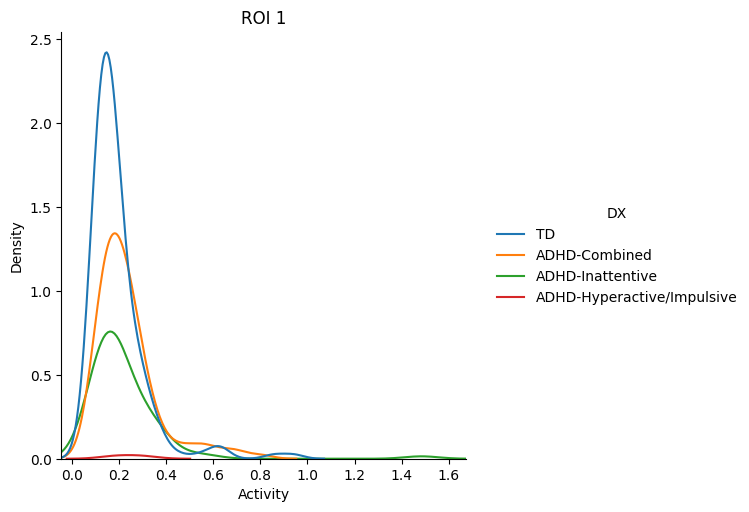

In [87]:
ax = sns.displot(data = var_pr_roi, x = 'ROI_1',hue='DX', kind= 'kde')
ax.set(title='ROI 1', xlabel='Activity', xlim=[x_min_var, x_max_var])

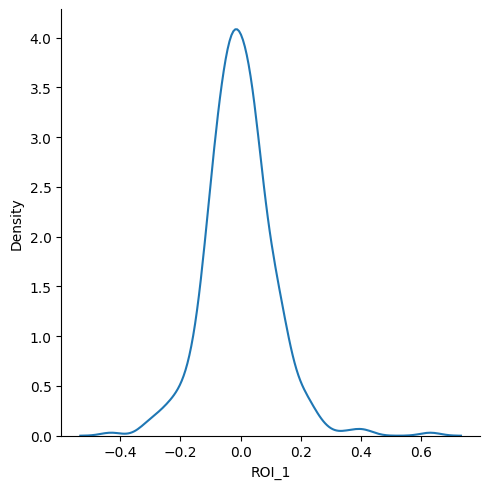

In [15]:
sns.displot(mean_pr_roi['ROI_1'], kind= 'kde')

In [16]:
var_pr_roi

,Subject_ID,Session,Rest,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ScanDir ID,Gender,DX
0,3662296,1,1,0.142888,0.150762,0.170962,0.185499,0.120572,0.163543,0.196198,3662296,Female,TD
1,0010097,1,1,0.113084,0.096357,0.092602,0.112406,0.127484,0.120382,0.131933,0010097,Female,TD
2,0010064,1,1,0.115571,0.093272,0.142835,0.129178,0.117899,0.159768,0.162086,0010064,Male,ADHD-Combined
3,0010056,1,2,0.141436,0.117431,0.131250,0.121396,0.311922,0.131031,0.156478,0010056,Male,ADHD-Inattentive
4,4562206,1,1,0.172666,0.162733,0.196089,0.171016,0.132022,0.225070,0.209657,4562206,Female,TD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,3349205,1,1,0.140984,0.239341,0.179246,0.242462,0.286837,0.243227,0.311321,3349205,Female,ADHD-Inattentive
390,2054438,1,2,0.238455,0.282816,0.255975,0.337184,0.191245,0.287595,0.353493,2054438,Male,ADHD-Combined
391,0010107,1,1,0.081131,0.071144,0.085435,0.083739,0.067047,0.097005,0.109105,0010107,Male,ADHD-Inattentive
392,1127915,1,1,0.120470,0.106113,0.145853,0.127871,0.110404,0.129048,0.187911,1127915,Female,TD


In [17]:
sns.heatmap(var_pr_roi.loc[:, var_pr_roi.columns != "subject"]) # outlier brain is LIT UP!!

ValueError: could not convert string to float: 'Female'

<Axes: >

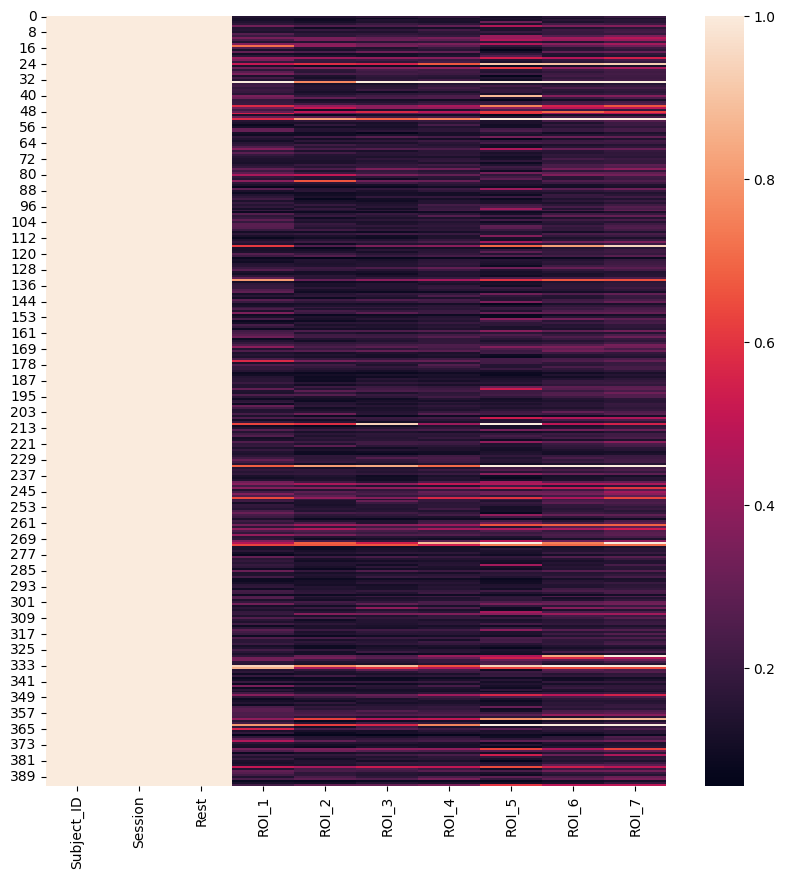

In [ ]:
plt.figure(figsize=(10, 10))

sns.heatmap(var_pr_roi.loc[:, var_pr_roi.columns != "subject"], vmax = 1) # if we ignore huge values

In [ ]:
plt.figure(figsize=(10, 10))

sns.heatmap(means_pr_roi.loc[:, means_pr_roi.columns != "subject"],vmax = 0.35,vmin =-0.35,cmap="vlag") # if we ignore huge values

NameError: name 'means_pr_roi' is not defined

<Figure size 1000x1000 with 0 Axes>

In [ ]:
means_pr_roi.loc[:, means_pr_roi.columns != "subject"].corr()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
ROI_1,1.000000,-0.004281,0.273202,-0.178301,-0.262438,-0.184918,-0.257364
ROI_2,-0.004281,1.000000,0.250024,0.521167,-0.195290,-0.202469,-0.197978
ROI_3,0.273202,0.250024,1.000000,-0.034028,-0.490056,0.085564,-0.612350
ROI_4,-0.178301,0.521167,-0.034028,1.000000,-0.025159,0.155738,0.030377
ROI_5,-0.262438,-0.195290,-0.490056,-0.025159,1.000000,0.148449,0.639977
ROI_6,-0.184918,-0.202469,0.085564,0.155738,0.148449,1.000000,0.283252
ROI_7,-0.257364,-0.197978,-0.612350,0.030377,0.639977,0.283252,1.000000


In [ ]:
var_pr_roi.loc[:, var_pr_roi.columns != "subject"].corr()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
ROI_1,1.000000,0.999059,0.998854,0.999090,0.894711,0.957749,0.984669
ROI_2,0.999059,1.000000,0.999331,0.999582,0.899221,0.961239,0.986892
ROI_3,0.998854,0.999331,1.000000,0.999355,0.904799,0.965385,0.988938
ROI_4,0.999090,0.999582,0.999355,1.000000,0.903254,0.963715,0.988532
ROI_5,0.894711,0.899221,0.904799,0.903254,1.000000,0.980196,0.954871
ROI_6,0.957749,0.961239,0.965385,0.963715,0.980196,1.000000,0.992524
ROI_7,0.984669,0.986892,0.988938,0.988532,0.954871,0.992524,1.000000


<Axes: >

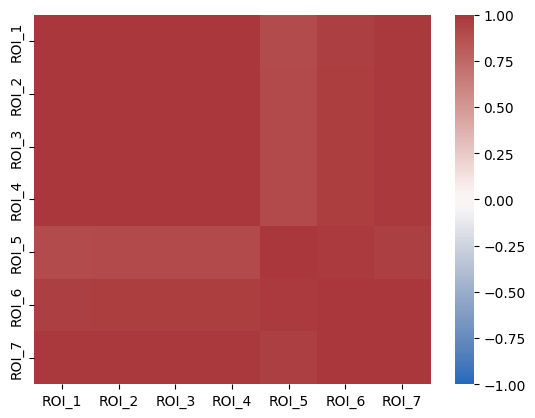

In [ ]:
sns.heatmap(var_pr_roi.loc[:, var_pr_roi.columns != "subject"].corr(),cmap = "vlag", vmax=1,vmin=-1)

<Axes: >

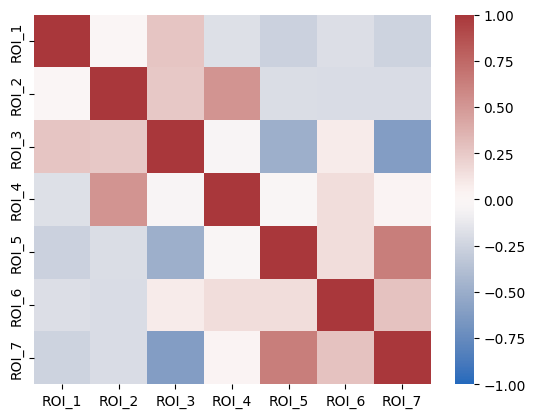

In [ ]:
sns.heatmap(means_pr_roi.loc[:, means_pr_roi.columns != "subject"].corr(),cmap = "vlag", vmax=1,vmin=-1)

## TODO
&#x2611; explore variance strangeness

&#x2611; explore means in same way
* Visualizing global patterns over time https://nilearn.github.io/dev/auto_examples/01_plotting/plot_carpet.html
* region activity over time https://nilearn.github.io/dev/auto_examples/06_manipulating_images/plot_nifti_labels_simple.html#sphx-glr-auto-examples-06-manipulating-images-plot-nifti-labels-simple-py


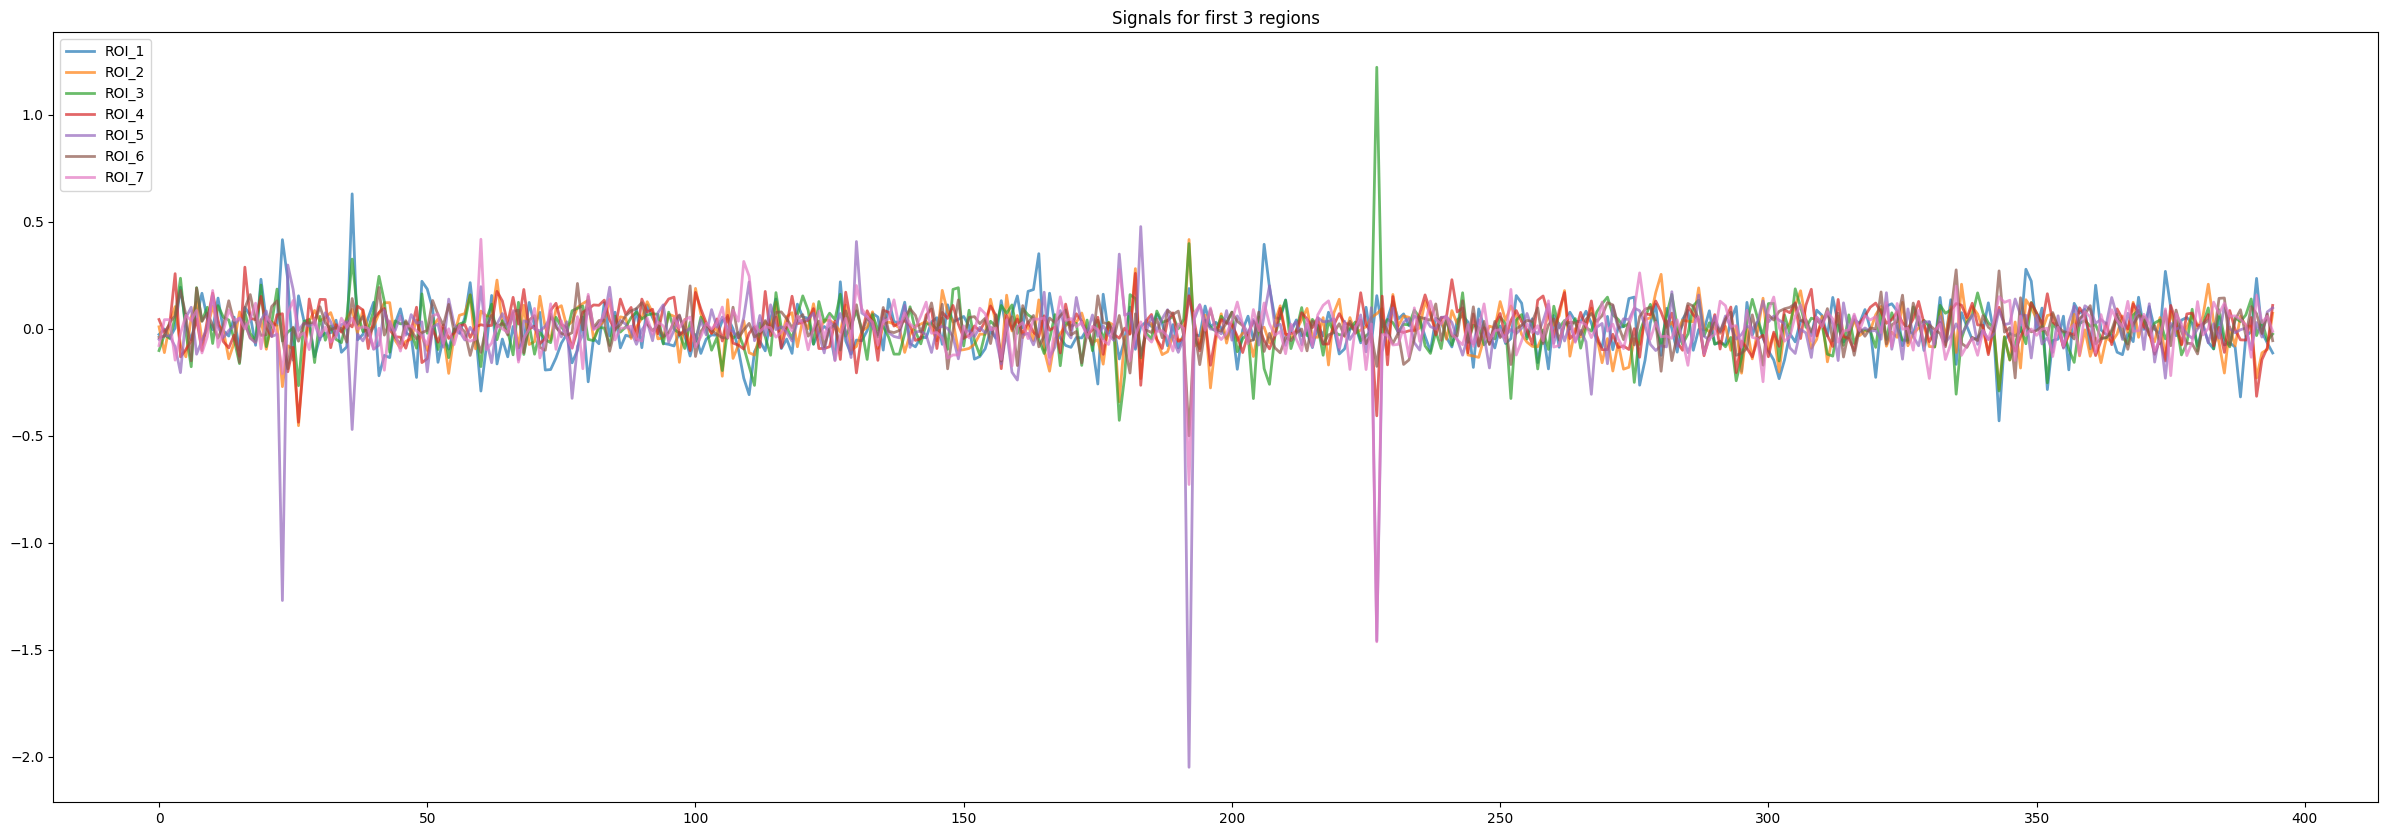

In [ ]:
#WRONG! TODO fix, see below :)
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)


for i in means_pr_roi.loc[:, means_pr_roi.columns != "subject"]: #For each ROI 
    ax.plot(
        means_pr_roi[i], linewidth=2, label=i,alpha = 0.7
            ) #would be super cool to align the colour to a diagnosis #TODO exclude huge values

ax.legend(loc=2)
ax.set_title("Signals for first 3 regions")
plt.show()

In [ ]:
# for subject in tqdm(file_list): #For each subject

#     subject = np.load(f'data/clean/NYU/{subject}')
#     for i in subject.files: #For each ROI 
#         if i != "allow_pickle": #TODO fix, there is a strange "Allow pickle thing here sometimes??"
#             roi = subject[i]
#             values = pd.DataFrame()
#             #Get all values from each timestep
#             for t in range(roi.shape[0]):
#                 values[t] = roi[t] #appends
#     break
